In [ ]:
!pip install --quiet grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from torch import nn, utils
import gc
import torchvision
from torchvision import datasets, transforms
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

files = {
    "list_eval_partition.csv": "1kDqtHZHpYMe7rt1zu9pOevzUbApkDNRa",
    "list_attr_celeba.csv": "1s8CyrddcxHdvwro-_M25H7uxsDWL_1Bs",
    "img_align_celeba.zip": "1mGM-w9373aW5UJ27xa5oAsesL06JOe3h",
}

root = "celeba/"


In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes: int = 1, num_blocks: int = 18):
        super().__init__()
        model = getattr(torchvision.models, f"resnet{num_blocks}")
        self.resnet = model(weights=f"ResNet{num_blocks}_Weights.DEFAULT")
        in_features = self.resnet.fc.in_features

        del self.resnet.fc
        gc.collect()

        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


In [ ]:
class BlondCelebA(utils.data.Dataset):
    def __init__(self, root, transform_data, split: int = 0):
        super().__init__()
        self.root = root
        self.transform_data = transform_data
        filename = os.path.join(root, "list_attr_celeba.csv")
        df = pd.read_csv(filename, delim_whitespace=True, header=1, index_col=0)

        dfp = pd.read_csv(
            os.path.join(root, "list_eval_partition.csv"),
            index_col=0,
            header=None,
            delim_whitespace=True
        )
        indexes = dfp[dfp.iloc[:, 0] == split].index

        df = df[["Blond_Hair", "Male"]].loc[indexes, :]
        df.rename(columns={"Blond_Hair": "label", "Male": "spurious_label"}, inplace=True)
        for c in df.columns:
            df[c] = df[c].apply(lambda x: 0 if x==-1 else 1)
        df["group"] = df.apply(lambda x: 2*x["label"]+x["spurious_label"], axis=1)
        self.df = df

    @property
    def transform(self):
        transform = transforms.Compose(
            [
                transforms.CenterCrop(178),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )
        return transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        sample = self.df.iloc[index, :]
        filename = os.path.join(self.root, "img_align_celeba/", sample.name)
        image = Image.open(filename).convert("RGB")
        if self.transform_data:
            image = self.transform(image)
        else:
            transform = transforms.Compose(
                [
                    transforms.CenterCrop(178),
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                ]
            )
            image = transform(image)
        return (
            image,
            sample.name,
            torch.tensor(sample["label"]),
            torch.tensor(sample["spurious_label"]),
            torch.tensor(sample["group"]),
        )

def download(root, files) -> None:
    def _check_integrity(root, files) -> bool:
        for filename, _ in files.items():
            fpath = os.path.join(root, filename)
            _, ext = os.path.splitext(filename)
            if ext not in [".zip", ".7z"] and not datasets.utils.check_integrity(fpath):
                return False

    if _check_integrity(root, files):
        print("Files already downloaded and verified")
        return

    for filename, file_id in files.items():
        if filename.startswith("resnet"):
            t = os.path.join("checkpoints/", filename.replace(".zip", "/"))
        else:
            t = root
        datasets.utils.download_file_from_google_drive(file_id, t, filename)
        if filename.endswith(".zip"):
            f = os.path.join(t, filename)
            datasets.utils.extract_archive(f)

os.makedirs(root, exist_ok=True)
download(root, files)


2836386it [00:00, 193457437.93it/s]
26721026it [00:00, 128452517.72it/s]
1443490838it [00:21, 67495877.39it/s] 


In [ ]:
@torch.no_grad()
def rename_state_dict(state_dict: OrderedDict) -> OrderedDict:
    new_state_dict = OrderedDict()
    for k in state_dict.keys():
        new_state_dict[k.replace("model.", "")] = state_dict[k]
    return new_state_dict

def gradcam_visualization(model, image):
    model.eval()

    target_layers = [model.resnet.layer4[-1]]
    cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)
    targets = [ClassifierOutputTarget(0)]

    grayscale_cam = cam(
        input_tensor=image,
        targets=targets,
        aug_smooth=True,
        eigen_smooth=True,
    )

    grayscale_cam = grayscale_cam[0, :]

    image = transforms.functional.to_pil_image(image.squeeze(0)).convert("RGB")
    image = np.array(image, dtype="float32")
    image /= image.max()

    visualization = show_cam_on_image(
        image,
        grayscale_cam,
        use_rgb=True
    )
    return visualization


In [ ]:
dataset = BlondCelebA(root, False, split=0)

In [ ]:
x1 = dataset[10][0].unsqueeze(0)
x2 = dataset[100][0].unsqueeze(0)
x3 = dataset[101][0].unsqueeze(0)

In [ ]:
x1.size()

torch.Size([1, 3, 224, 224])

In [ ]:
model = ResNet(1, 18)
checkpoint = torch.load("/content/checkpoint-epoch=001-valid_bceloss=0.10696-valid_accuracy=0.95611.ckpt", map_location=device)
state_dict = checkpoint.get("state_dict")
state_dict = rename_state_dict(state_dict)
model.load_state_dict(state_dict)


<All keys matched successfully>

In [ ]:
v1 = gradcam_visualization(model, x1)
v2 = gradcam_visualization(model, x2)
v3 = gradcam_visualization(model, x3)


100%|██████████| 16/16 [00:40<00:00,  2.50s/it]


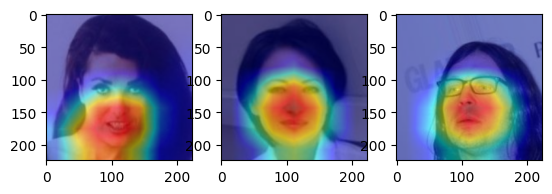

In [ ]:
fig, ax = plt.subplots(1, 3)
ax = ax.flatten()
ax[0].imshow(v1)
ax[1].imshow(v2)
q = ax[2].imshow(v3)

100%|██████████| 16/16 [00:40<00:00,  2.52s/it]


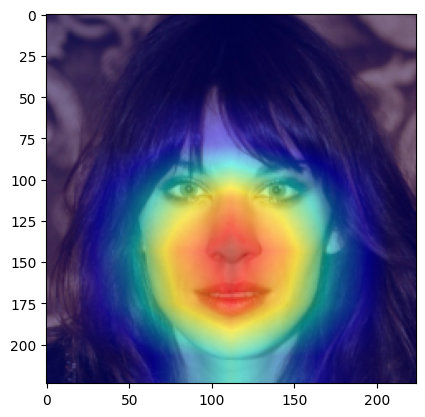

In [ ]:
image = Image.open("image.jpg").convert("RGB")
transform = transforms.Compose(
    [
        # transforms.CenterCrop(178),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)
image = transform(image).unsqueeze(0)
v = gradcam_visualization(model, image)
plt.imshow(v)
